# [SOC-5] Analysis of Quantitative Data Discussion

---

*Estimated Time: 50 minutes*

---

### Topics Covered
- Chi-Square Statistic
- t Tests
- Linear Least-squares Regression
    - R Statistic

### Table of Contents

[The Data](GSS 2014 data)<br>

[Context]<br>

1 - [Section 1](Chi-Square Statistic)<br>

2 - [Section 2](t Tests)<br>

3 - [Section 3](Linear Least-squares Regression)<br>

In [1]:
from datascience import *
%matplotlib inline
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

---

## The Data <a id='data'></a>
Explanation of the data the students will be working with. 

<b>Example</b>: In this notebook, you'll be working with ..............


In [2]:
gss_survey_data = Table.read_table("Data/GSS_2014_data.csv")

gss_survey_data = gss_survey_data.where("AGE", are.between('0','89'))
gss_survey_data = gss_survey_data.where("SEX", are.between_or_equal_to('1','2'))
gss_survey_data = gss_survey_data.where("EDUC", are.between_or_equal_to('0','96'))
gss_survey_data = gss_survey_data.where("NATEDUC", are.between_or_equal_to('1','4'))
gss_survey_data = gss_survey_data.where("NATFARE", are.between_or_equal_to('1','4'))
gss_survey_data = gss_survey_data.where("NATROAD", are.between_or_equal_to('1','4'))
gss_survey_data = gss_survey_data.where("NATMASS", are.between_or_equal_to('1','4'))
gss_survey_data = gss_survey_data.where("NATHEAL", are.between_or_equal_to('1','4'))
gss_survey_data = gss_survey_data.where("NATENVIR", are.between_or_equal_to('1','4'))

for label in gss_survey_data.labels:
    gss_survey_data = gss_survey_data.with_column(label, gss_survey_data.column(label).astype(int))
    
gss_survey_data

CASEID,SEX,EDUC,AGE,NATEDUC,NATFARE,NATROAD,NATMASS,NATHEAL,NATENVIR
58649,1,0,41,1,1,1,1,1,1
58007,2,0,78,1,1,2,3,1,3
58356,2,1,34,1,1,2,2,2,1
57246,2,3,56,1,1,2,1,2,1
58427,1,5,38,1,2,2,1,1,2
59067,1,5,64,1,1,1,1,1,1
57446,1,6,39,1,2,2,2,2,2
57633,1,6,55,1,1,2,2,1,1
57913,1,6,50,1,2,3,2,1,1
58127,1,6,59,1,3,2,2,1,1


## Section 1: Chi-Square Statistic  <a id='section 1'></a>

Intro to section 1 here.

In [3]:
contigTable = gss_survey_data.groups(["NATMASS", "NATENVIR"]).pivot("NATMASS", "NATENVIR", values="count", collect=np.sum)
contigTable = contigTable.with_column("total", [np.sum(list(contigTable.row(n))[1:]) for n in np.arange(0, len(contigTable)-1)])
contigTable = contigTable.with_row(["total", 610, 795, 130, 1535])
contigTable

NATENVIR,1,2,3,total
1,419,455,55,929
2,152,282,38,472
3,39,58,37,134
total,610,795,130,1535


In [4]:
expected = [[contigTable.column("total")[row]*(contigTable.column(col)[3]/1535) for col in ["1", "2", "3"]] for row in [0, 1, 2]]
observed = [[contigTable.column(col)[row] for col in ["1", "2", "3"]] for row in [0, 1, 2]]
expected = np.concatenate(expected).ravel()
observed = np.concatenate(observed).ravel()

chi_squared = np.sum((expected-observed)**2/expected)
degree_freedom = 4

print("chi-squared statistic = " + str(chi_squared))
print("degrees of freedom = " + str(degree_freedom))

chi-squared statistic = 91.5457976538473
degrees of freedom = 4


The critical chi-squared statistic for a 0.05 probability level (p value) and a degree of freedom of 4 is 9.488. Knowing this, is there a significant correlation between NATENVIR and NATMASS? Explain your answer.

---

## Section 2: t tests <a id='section 2'></a>

Intro to section 2 here.

In [9]:
lst = ["NATEDUC", "NATFARE", "NATROAD", "NATMASS", "NATHEAL", "NATENVIR"]
females = gss_survey_data.where("SEX", are.equal_to(2))
data = [females[col] for col in lst]
mean_values = [np.mean(col) for col in data]
std_values = [np.std(col) for col in data]
means_female = Table().with_column("category (female)", lst).with_columns("mean", mean_values, "standard deviation", std_values)

print("female sample size = " + str(females.num_rows))
means_female

female sample size = 807


category (female),mean,standard deviation
NATEDUC,1.28996,0.56339
NATFARE,2.2689,0.79235
NATROAD,1.70012,0.7
NATMASS,1.71499,0.601988
NATHEAL,1.51177,0.717664
NATENVIR,1.48203,0.638975


In [10]:
males = gss_survey_data.where("SEX", are.equal_to(1))
data = [males[col] for col in lst]
mean_values = [np.mean(col) for col in data]
std_values = [np.std(col) for col in data]
means_male = Table().with_column("category (male)", lst).with_column("mean", mean_values, "standard deviation", std_values)

print("male sample size = " + str(males.num_rows))
means_male

male sample size = 728


category (male),mean,standard deviation
NATEDUC,1.36401,0.602806
NATFARE,2.24588,0.769426
NATROAD,1.53846,0.645061
NATMASS,1.65659,0.637807
NATHEAL,1.55082,0.709162
NATENVIR,1.48214,0.664822


In [11]:
s_p = ((females.num_rows - 1)*(0.56339)**2 + (males.num_rows - 1)*(0.602806)**2)/(males.num_rows + females.num_rows - 2)**.5
t = (1.28996 - 1.36401)/(s_p*(1/females.num_rows + 1/males.num_rows)**.5)
print("t value = " + str(t))

t value = -0.10907797999177248


The critical t value for siginificance level of 0.05 and degrees of freedom of 1533 (= total female sample + total male sample - 2) is 1.645848. Knowing this, what can we say about our null hypothesis?

## Section 3: Linear Regression <a id='section 3'></a>

Intro to section 3 here.

### R statistic <a id='subsection 1'></a>

Intro to subsection 1 here.

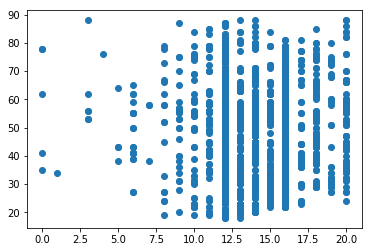

In [17]:
plt.scatter(gss_survey_data["EDUC"], gss_survey_data["AGE"])
plt.show()

regression line : y=0.006933189184531947x + 13.564512011776326
r value = 0.038030881150196545


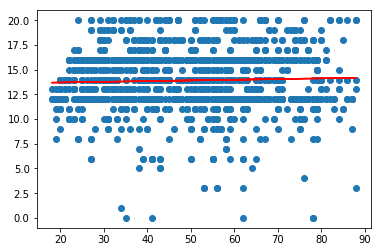

In [14]:
m, c, r_value, p_value, std_err = stats.linregress(gss_survey_data["AGE"], gss_survey_data["EDUC"])
plt.plot(gss_survey_data["AGE"], gss_survey_data["EDUC"], 'o', label='Original data')
plt.plot(gss_survey_data["AGE"], m*gss_survey_data["AGE"] + c, 'r', label='Fitted line')

print("regression line : y=" + str(m) +"x + " + str(c))
print("r value = "+ str(r_value))
plt.show()

In [18]:
grouped_educ

EDUC,CASEID mean,SEX mean,AGE mean,NATEDUC mean,NATFARE mean,NATROAD mean,NATMASS mean,NATHEAL mean,NATENVIR mean
0,58740.8,1.6,58.8,1.6,1.4,1.8,2.2,1.4,2.2
1,58356,2,34,1,1,2,2,2,1
3,57767.8,1.83333,61.3333,2,2.16667,2.33333,1.66667,1.83333,2
4,59178,1,76,2,2,2,2,2,2
5,57909.5,1.5,47,1.5,1.75,1.75,1.5,1.5,1.75
6,57865.6,1.66667,47.1905,1.52381,2.09524,2.38095,1.95238,1.38095,1.47619
7,58266.3,1,51.3333,1,2.33333,1,1.66667,1,1.66667
8,58477.6,1.58824,49.6471,1.41176,2.23529,2,1.70588,1.58824,1.52941
9,58652.6,1.36,50.48,1.6,2.32,1.84,1.88,1.44,1.56
10,57912.2,1.53191,47.5106,1.25532,2.3617,1.76596,1.85106,1.48936,1.7234


In [19]:
grouped_educ

EDUC,CASEID mean,SEX mean,AGE mean,NATEDUC mean,NATFARE mean,NATROAD mean,NATMASS mean,NATHEAL mean,NATENVIR mean
0,58740.8,1.6,58.8,1.6,1.4,1.8,2.2,1.4,2.2
1,58356,2,34,1,1,2,2,2,1
3,57767.8,1.83333,61.3333,2,2.16667,2.33333,1.66667,1.83333,2
4,59178,1,76,2,2,2,2,2,2
5,57909.5,1.5,47,1.5,1.75,1.75,1.5,1.5,1.75
6,57865.6,1.66667,47.1905,1.52381,2.09524,2.38095,1.95238,1.38095,1.47619
7,58266.3,1,51.3333,1,2.33333,1,1.66667,1,1.66667
8,58477.6,1.58824,49.6471,1.41176,2.23529,2,1.70588,1.58824,1.52941
9,58652.6,1.36,50.48,1.6,2.32,1.84,1.88,1.44,1.56
10,57912.2,1.53191,47.5106,1.25532,2.3617,1.76596,1.85106,1.48936,1.7234


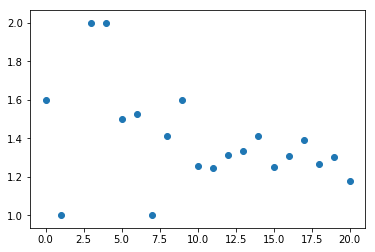

In [15]:
grouped_educ = gss_survey_data.group("EDUC", np.mean)
plt.scatter(grouped_educ["EDUC"], grouped_educ["NATEDUC mean"])
plt.show()

In [16]:
def squared_error(ys_orig,ys_line):
    return sum((ys_line - ys_orig) * (ys_line - ys_orig))

def coefficient_of_determination(ys_orig,ys_line):
    y_mean_line = [np.mean(ys_orig) for y in ys_orig]
    squared_error_regr = squared_error(ys_orig, ys_line)
    squared_error_y_mean = squared_error(ys_orig, y_mean_line)
    return (1 - (squared_error_regr/squared_error_y_mean))

@interact(m=(-50, 0), c=(100, 200))
def g(m, c):
    est = m/1000*grouped_educ["EDUC"] + c/100
    plt.plot(grouped_educ["EDUC"], grouped_educ["NATEDUC mean"], 'o', label='Original data')
    plt.plot(grouped_educ["EDUC"], est, 'r', label='Fitted line')
    plt.show()
    
    return "y="+str(m/1000)+"x+"+str(c/100)+"     r^2="+str(coefficient_of_determination(grouped_educ["NATEDUC mean"], est))

interactive(children=(IntSlider(value=-25, description='m', max=0, min=-50), IntSlider(value=150, description=…

regression line : y=-0.0173075319239169x + 1.574827814793762
r^2 value = 0.161051339483865


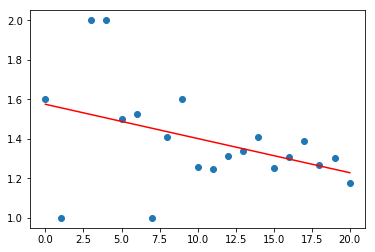

In [20]:
m, c, r_value, p_value, std_err = stats.linregress(grouped_educ["EDUC"], grouped_educ["NATEDUC mean"])
plt.plot(grouped_educ["EDUC"], grouped_educ["NATEDUC mean"], 'o', label='Original data')
plt.plot(grouped_educ["EDUC"], m*grouped_educ["EDUC"] + c, 'r', label='Fitted line')

print("regression line : y=" + str(m) +"x + " + str(c))
print("r^2 value = "+ str(r_value**2))
plt.show()

___
## Survey

Have any feedback about this notebook? Please fill out our survey:

https://docs.google.com/forms/d/e/1FAIpQLSe54U3E64kYFWwQHSUpAvWYMuJOdKzbHDZjPa3nMUlHSSs0PQ/viewform

---

## Bibliography

Cite sources in this format, separated with bullet points:

<b>Format</b>: `Author` - `How source was used`. `URL`

Example:

- John Denero - Adapted NLP techniques. https://denero.org

---
Notebook developed by: X, X, X

Data Science Modules: http://data.berkeley.edu/education/modules
